Instalación de packages

In [ ]:



install.packages("RODBC")
install.packages("survival")
install.packages("KMsurv")
install.packages("survMisc")
install.packages("survminer")
install.packages("ggfortify")
install.packages("flexsurv")
install.packages("actuar")
install.packages("car")
install.packages("e1071")
install.packages("rms")
install.packages("fastDummies")
install.packages("expss")





library(RODBC)
library(survival)
library(KMsurv)
library(survMisc)
library(survminer)
library(ggfortify)
library(flexsurv)
library(actuar)
library(car)
library(e1071)
library(rms)
library(dummies)
library(fastDummies)
library(expss)







Conectamos R con SQL mediante ODBC para extraer la base de datos desde el servidor local.

In [2]:
canal_bd <-odbcDriverConnect('driver={SQL Server};
                             server=LAPTOP-SRBMTPNS;
                             database=TestFalabella;
                             trusted_connection=true')

Importando la tabla desde SQL.

In [3]:
Sobrevida <- sqlQuery(canal_bd, '

select * from SobrevidaUchile
                         
                         ')

Descripción de la data.

In [4]:
head(Sobrevida) 

tiempo,censura,estadio,tabaco,alcohol,antec
40.44244,0,0,0,1,1
39.93839,1,0,0,1,1
38.13508,1,0,0,1,1
35.77350,0,0,0,1,1
45.43808,1,0,0,1,1
31.93737,0,0,0,1,1


In [5]:
attach(Sobrevida)

In [6]:
str(Sobrevida) #caracteristicas de la base

'data.frame':	500 obs. of  6 variables:
 $ tiempo : num  40.4 39.9 38.1 35.8 45.4 ...
 $ censura: num  0 1 1 0 1 0 1 1 1 1 ...
 $ estadio: num  0 0 0 0 0 0 0 0 0 0 ...
 $ tabaco : num  0 0 0 0 0 0 0 0 0 0 ...
 $ alcohol: num  1 1 1 1 1 1 1 1 1 1 ...
 $ antec  : num  1 1 1 1 1 1 1 1 1 1 ...


En la data observamos 79 datos censurados.

In [7]:
cro(censura) 

,,#Total
censura,0,79
,1,421
,#Total cases,500


Se observar 3 estadíos de la enfermedad siendo el más frecuente el tercer estadío y el menos frecuente el primero, lo que hace suponer que en su mayoría son enfermos terminales.

In [8]:
cro(estadio) 

,,#Total
estadio,0,27
,1,200
,2,273
,#Total cases,500


Con respecto al hábito del tabaco se observa mucho desbalance, siendo en su gran mayoría fumadores.

In [9]:
cro(tabaco)

,,#Total
tabaco,0,64
,1,436
,#Total cases,500


Con respecto al consumo de alcohol también se observa mucho desbalance observándose mayoritariamente una muestra de la población que no es bebedora.

In [10]:
cro(alcohol)

,,#Total
alcohol,0,473
,1,27
,#Total cases,500


El 70% de los pacientes poseen antecedentes familiares de la enfermedad.

In [11]:
cro(antec)

,,#Total
antec,0,151
,1,349
,#Total cases,500


Al ensayar la sobrevida de Kaplan-Meier observamos que el resultado es el mismo observado en Stata, es decir, el 50% de los pacientes aún estaba vivo a los 37,6 meses

In [12]:
SRV <- survfit(Surv(tiempo, censura) ~ 1, data = Sobrevida, type = "kaplan-meier")

In [13]:
print(SRV,print.rmean=T)

Call: survfit(formula = Surv(tiempo, censura) ~ 1, data = Sobrevida, 
    type = "kaplan-meier")

         n     events     *rmean *se(rmean)     median    0.95LCL    0.95UCL 
   500.000    421.000     37.201      0.259     37.580     36.903     38.102 
    * restricted mean with upper limit =  53.9 


Al observar los percentiles notaremos que a los 33 meses estaba vivo el 75% de los pacientes.

In [94]:
print(quantile(SRV))

$quantile
      25       50       75 
33.00543 37.57973 41.21234 

$lower
      25       50       75 
32.66779 36.90338 40.28193 

$upper
      25       50       75 
34.00354 38.10236 42.09638 



Gráfcio de sobrevida de Kaplan-Meier

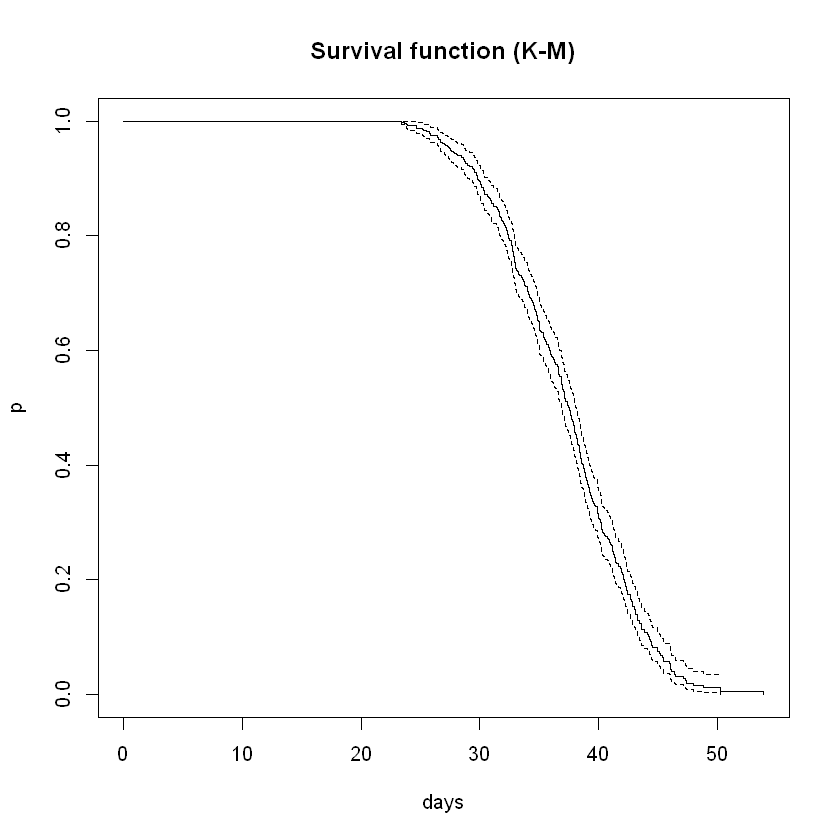

In [91]:
plot(SRV, main="Survival function (K-M)", xlab="days", ylab="p")

Gráfcio de riesgo aumulado de Nelson Aalen

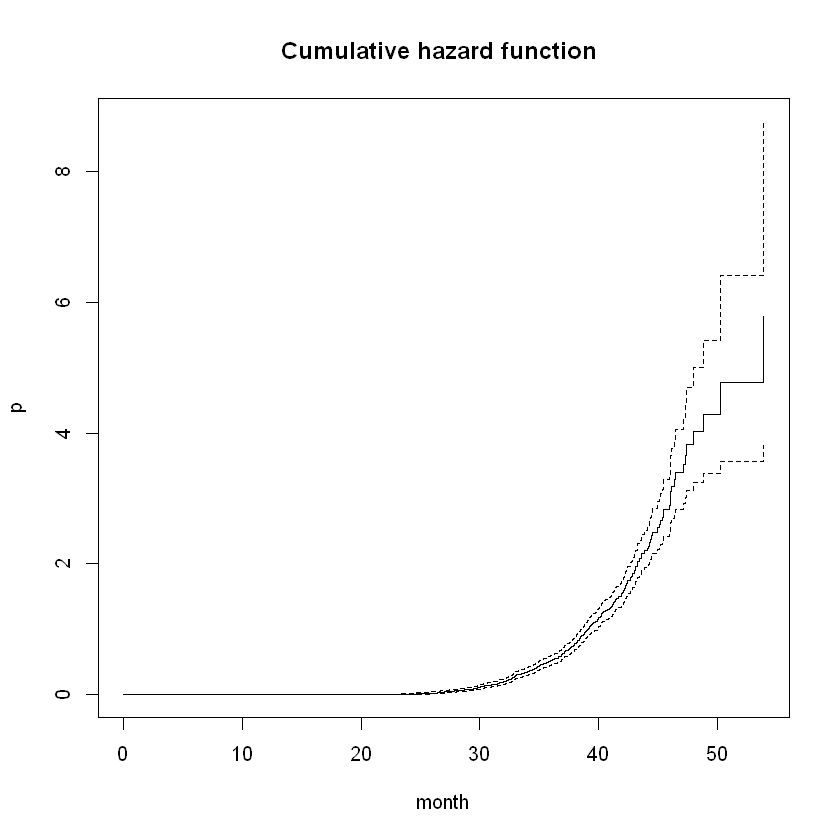

In [16]:
plot(SRV, fun="cumhaz", main="Cumulative hazard function ", xlab="month", ylab="p")

Analizaremos las curvas de sobrevida en cada grupo de cada covariable y aplicaremos la dócima de Log Rank para evaluar la existencia de diferencias significativas entre grupos. Por otro lado evaluaremos el supuesto de los riesgos proporcionales para validar la utilización del modelo semiparamétrico de Cox.

## Estadío

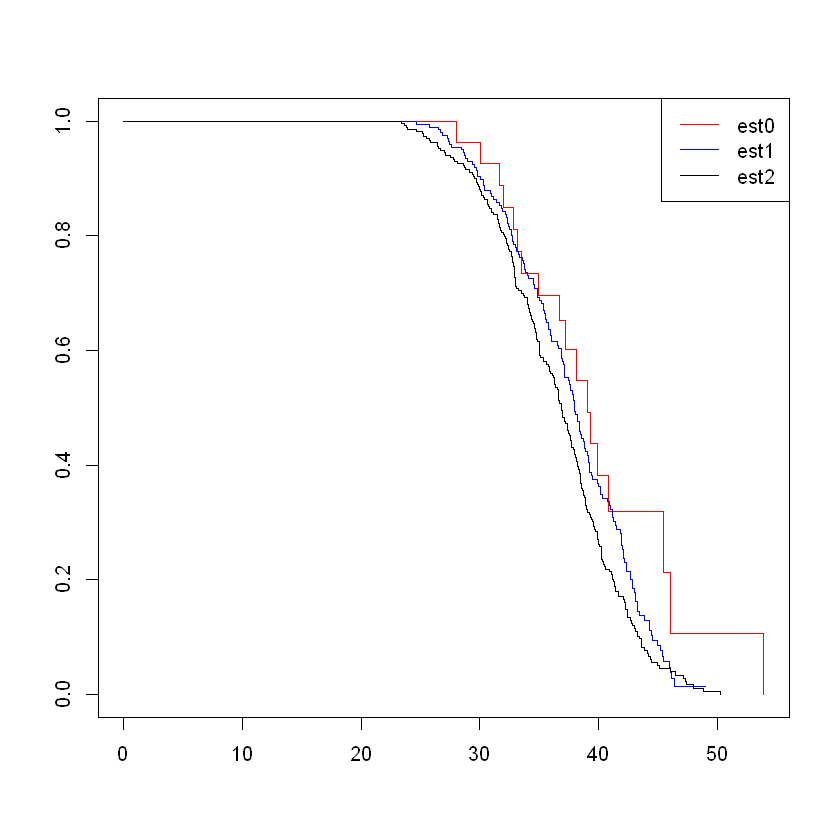

In [93]:
recsurv <- Surv(tiempo,censura)
leg.txt<-c("est0", "est1","est2")
fit_est <- survfit(recsurv~estadio)
plot(fit_est, col=c(2,4,1))
legend("topright",leg.txt,col=c(2,4,1),lty=1)

La dócima de Log Rank confirma la existencia diferencias significativas entre los 3 grupos. El resultado del estadístico es el mismo entregado por Stata.

In [18]:
surv<-Surv(tiempo,censura)
survdiff(surv ~ estadio, rho=0)

Call:
survdiff(formula = surv ~ estadio, rho = 0)

            N Observed Expected (O-E)^2/E (O-E)^2/V
estadio=0  27       18     29.2      4.32      4.88
estadio=1 200      160    175.9      1.44      2.50
estadio=2 273      243    215.8      3.42      7.07

 Chisq= 9.4  on 2 degrees of freedom, p= 0.009 

Para evaluar la proporcionalidad de los riesgos debemos construir el modelo de Cox de manera univariada y analizar las proporcionalidad.

In [19]:
fitcox_est <- coxph(surv~estadio)

In [20]:
summary(fitcox_est)

Call:
coxph(formula = surv ~ estadio)

  n= 500, number of events= 421 

           coef exp(coef) se(coef)     z Pr(>|z|)   
estadio 0.25457   1.28990  0.08382 3.037  0.00239 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
estadio      1.29     0.7753     1.094      1.52

Concordance= 0.537  (se = 0.014 )
Likelihood ratio test= 9.6  on 1 df,   p=0.002
Wald test            = 9.22  on 1 df,   p=0.002
Score (logrank) test = 9.27  on 1 df,   p=0.002


Logaritmizamos las curvas para evidenciar la proporcionalidad

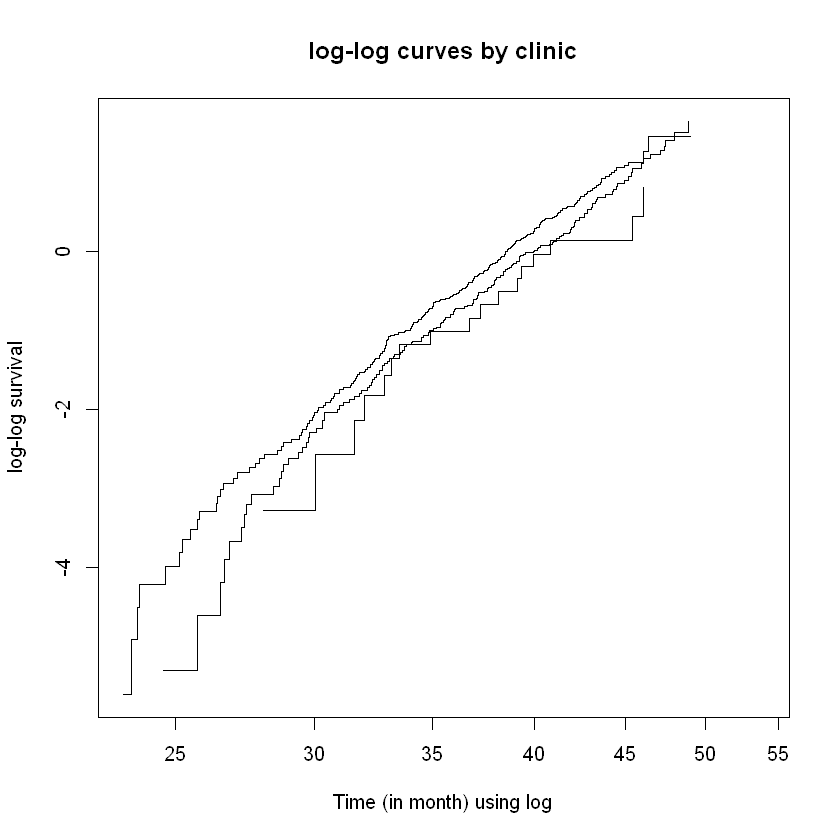

In [21]:
plot(fit_est, fun = "cloglog", xlab = "Time (in month) using log",
     ylab = "log-log survival", main = "log-log curves by clinic") 

Analizamos los residuos de schoenfeld

`geom_smooth()` using formula 'y ~ x'


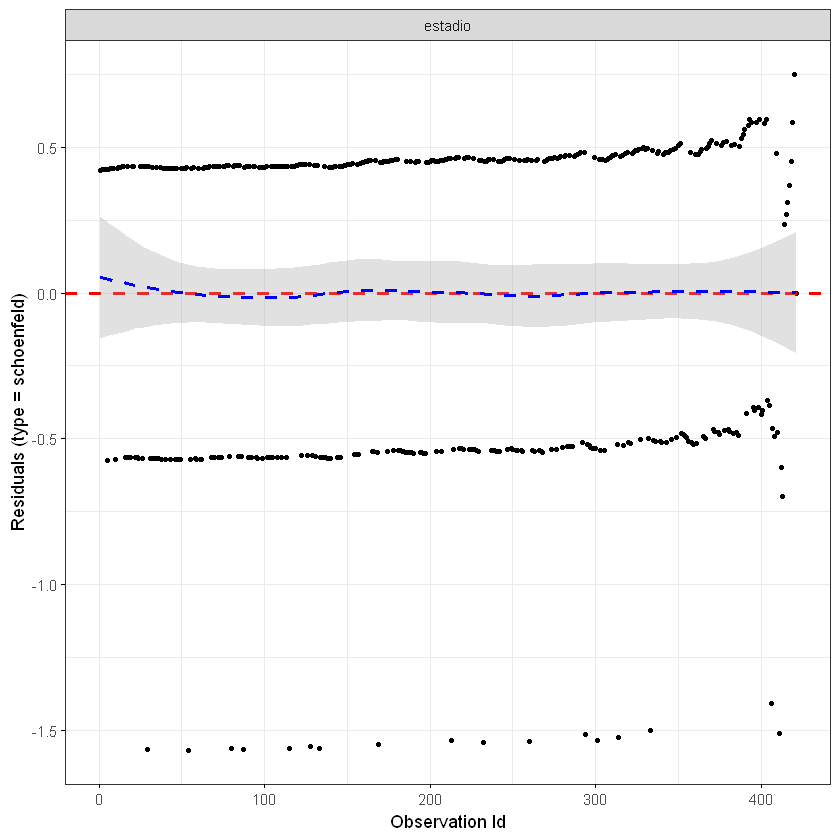

In [22]:
ggcoxdiagnostics(fitcox_est, type = "schoenfeld")

Aplicamos el tests de proporcionalidad. Finalmente se concluye que los riesgos son proporcionales

In [23]:
cox.zph(fitcox_est)

          chisq df    p
estadio 0.00752  1 0.93
GLOBAL  0.00752  1 0.93

Tabaco:
Los pacientes con hábito de tabaquismo parecen ser más riesgosos.

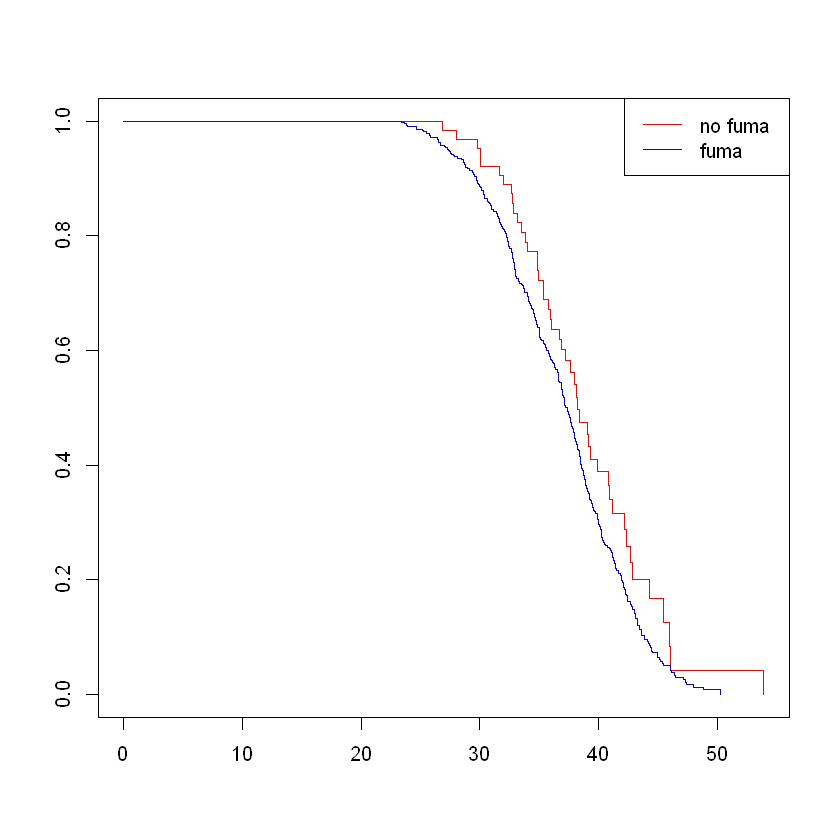

In [24]:
leg.txt<-c("no fuma", "fuma")
fit_tab <- survfit(recsurv~tabaco)
plot(fit_tab, col=c(2,4))
legend("topright",leg.txt,col=c(2,4),lty=1)

La dócima de Log Rank confirma un efecto significativo de la covariable sobre la variable de interés. El valor del estadístico es el mismo entregado por Stata.

In [25]:
survdiff(surv ~ tabaco, rho=0)

Call:
survdiff(formula = surv ~ tabaco, rho = 0)

           N Observed Expected (O-E)^2/E (O-E)^2/V
tabaco=0  64       46     60.5     3.483      4.14
tabaco=1 436      375    360.5     0.585      4.14

 Chisq= 4.1  on 1 degrees of freedom, p= 0.04 

Construimos el modelo de Cox para analizar las proporcionalidad de los riesgos.

In [26]:
fitcox_tab <- coxph(surv~tabaco)

In [27]:
summary(fitcox_tab)

Call:
coxph(formula = surv ~ tabaco)

  n= 500, number of events= 421 

         coef exp(coef) se(coef)     z Pr(>|z|)  
tabaco 0.3204    1.3776   0.1581 2.027   0.0427 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
tabaco     1.378     0.7259     1.011     1.878

Concordance= 0.518  (se = 0.009 )
Likelihood ratio test= 4.47  on 1 df,   p=0.03
Wald test            = 4.11  on 1 df,   p=0.04
Score (logrank) test = 4.14  on 1 df,   p=0.04


Logaritmizamos las curvas para evidenciar la proporcionalidad

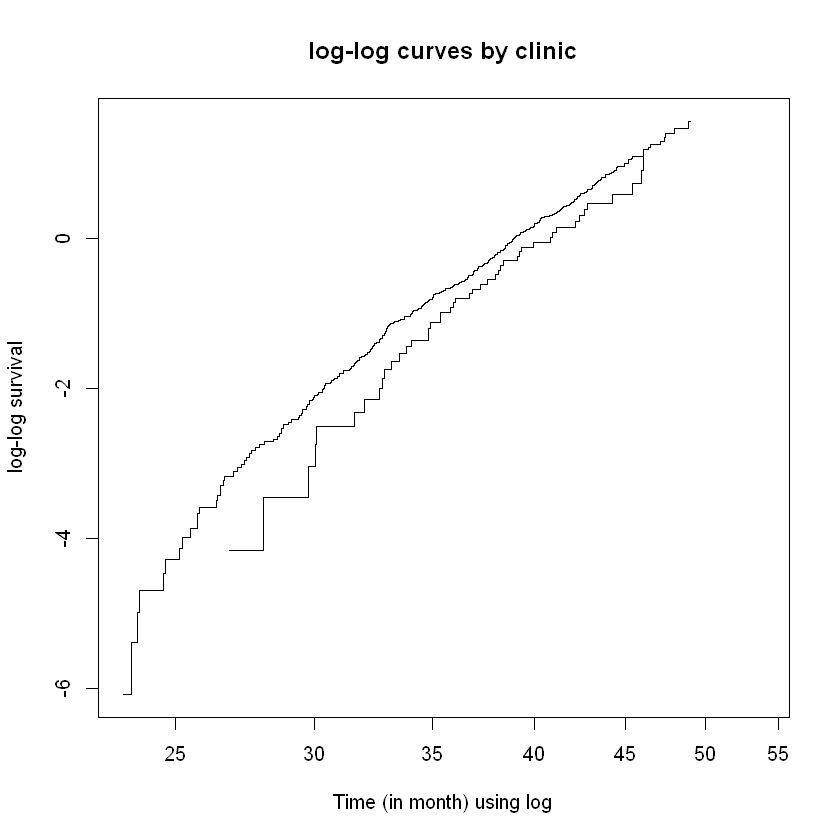

In [28]:
plot(fit_tab, fun = "cloglog", xlab = "Time (in month) using log",
     ylab = "log-log survival", main = "log-log curves by clinic") 

Analizamos los residuos de schoenfeld

`geom_smooth()` using formula 'y ~ x'


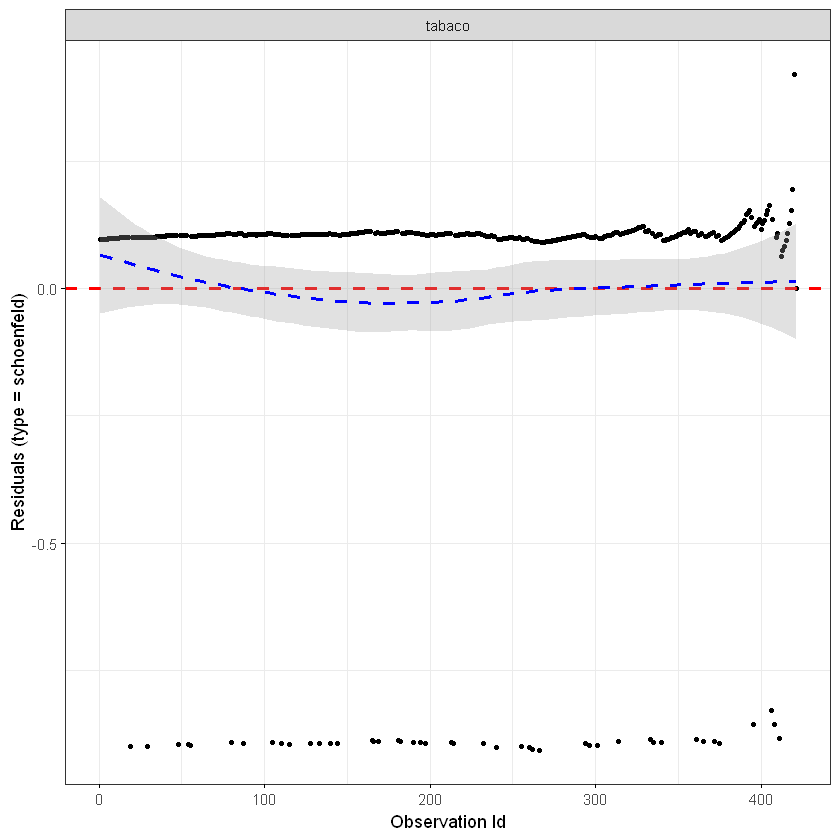

In [29]:
ggcoxdiagnostics(fitcox_tab, type = "schoenfeld")

Aplicamos el tests de proporcionalidad. Finalmente se concluye que los riesgos son proporcionales

In [30]:
cox.zph(fitcox_tab)

        chisq df    p
tabaco 0.0477  1 0.83
GLOBAL 0.0477  1 0.83

Alcohol:
Los pacientes con hábito de consumo de alcohol presentan una sobrevida superior.

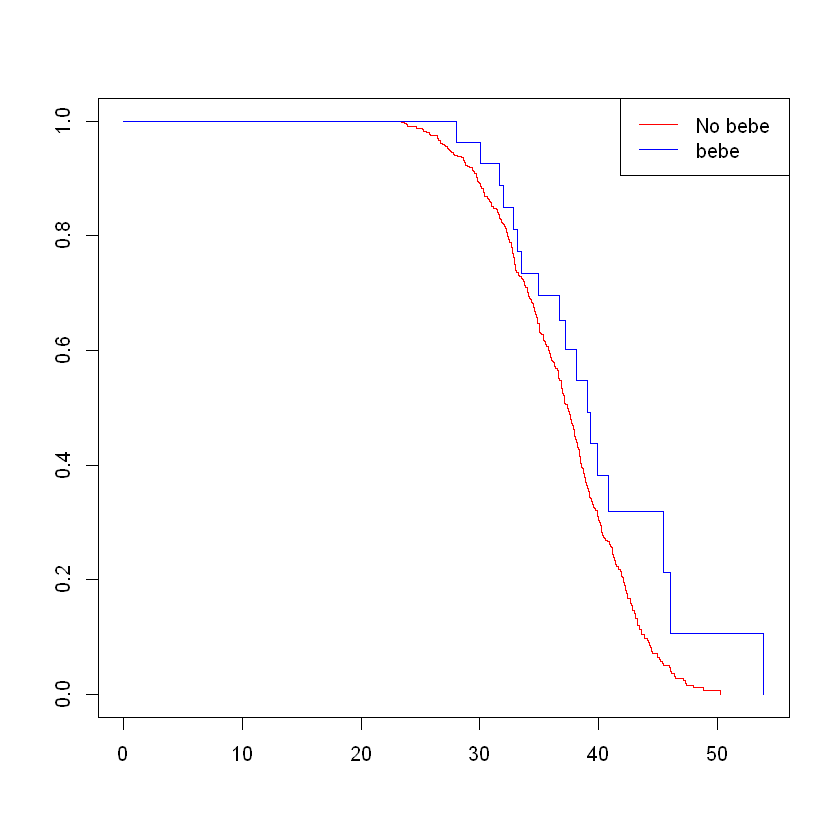

In [31]:
leg.txt<-c("No bebe", "bebe")
fit_alc <- survfit(recsurv~alcohol)
plot(fit_alc, col=c(2,4))
legend("topright",leg.txt,col=c(2,4),lty=1)

La dócima de Log Rank muestra un efecto significativo de la covariable sobre la variable de interés.

In [32]:
surv<-Surv(tiempo,censura)
survdiff(surv ~ alcohol, rho=0)

Call:
survdiff(formula = surv ~ alcohol, rho = 0)

            N Observed Expected (O-E)^2/E (O-E)^2/V
alcohol=0 473      403    391.8     0.323      4.88
alcohol=1  27       18     29.2     4.325      4.88

 Chisq= 4.9  on 1 degrees of freedom, p= 0.03 

Construimos el modelo de Cox univariado para analizar las proporcionalidad de los riesgos.

In [33]:
fitcox_alc <- coxph(surv~alcohol)

In [34]:
summary(fitcox_alc)

Call:
coxph(formula = surv ~ alcohol)

  n= 500, number of events= 421 

           coef exp(coef) se(coef)      z Pr(>|z|)  
alcohol -0.5438    0.5805   0.2492 -2.183   0.0291 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
alcohol    0.5805      1.723    0.3562     0.946

Concordance= 0.509  (se = 0.007 )
Likelihood ratio test= 5.63  on 1 df,   p=0.02
Wald test            = 4.76  on 1 df,   p=0.03
Score (logrank) test = 4.88  on 1 df,   p=0.03


Logaritmizamos las curvas para evidenciar la proporcionalidad

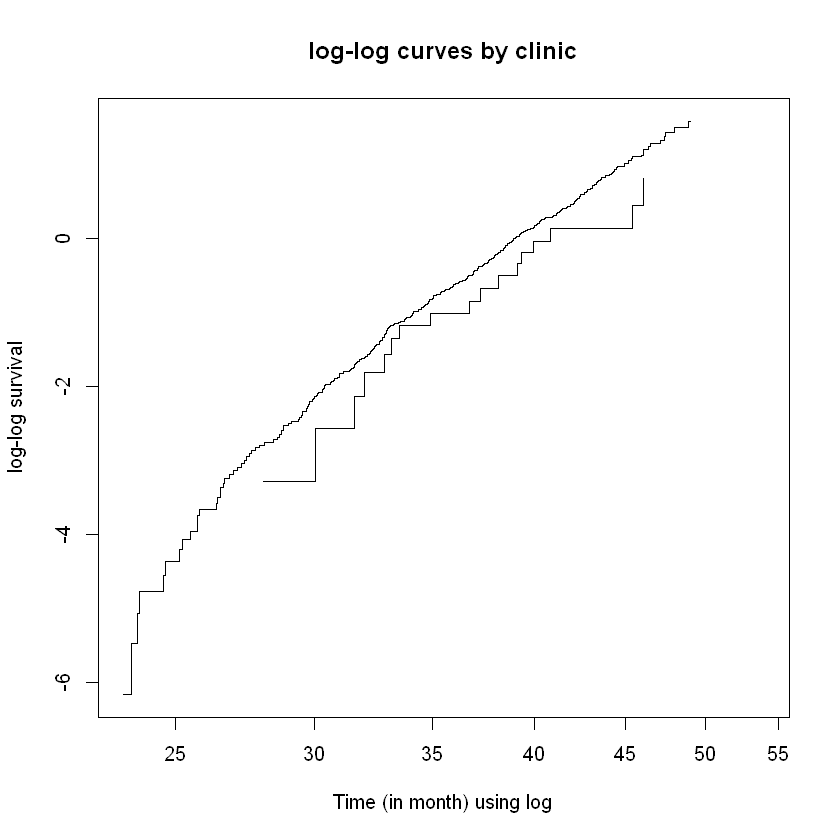

In [35]:
plot(fit_alc, fun = "cloglog", xlab = "Time (in month) using log",
     ylab = "log-log survival", main = "log-log curves by clinic") 

Analizamos los residuos de schoenfeld

`geom_smooth()` using formula 'y ~ x'


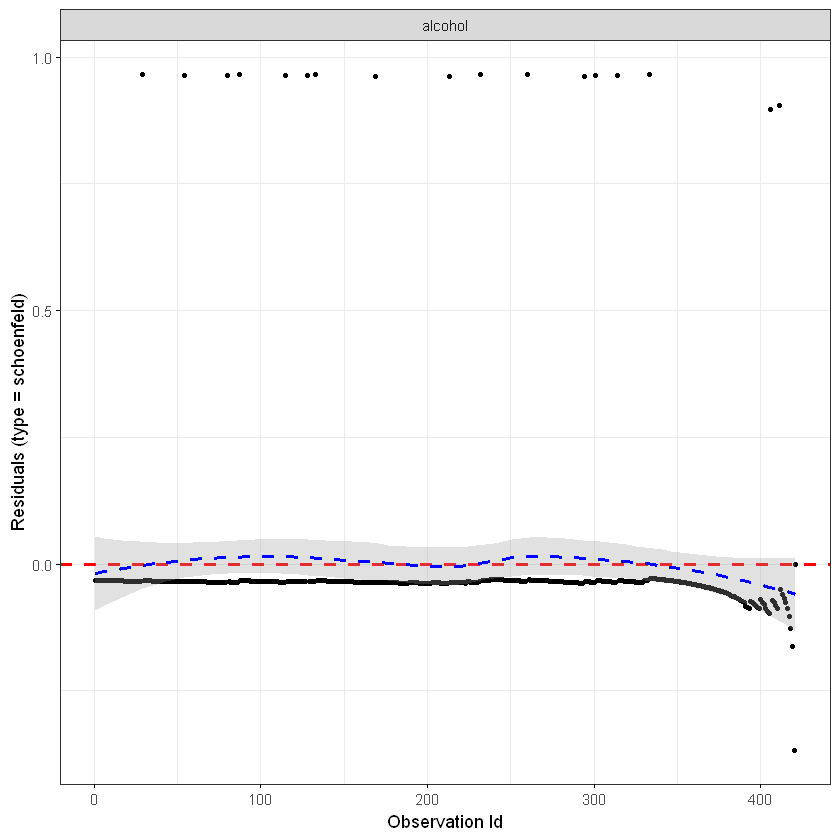

In [36]:
ggcoxdiagnostics(fitcox_alc, type = "schoenfeld")

Aplicamos el tests de proporcionalidad. Finalmente se concluye que los riesgos son proporcionales

In [37]:
cox.zph(fitcox_alc)

        chisq df    p
alcohol 0.971  1 0.32
GLOBAL  0.971  1 0.32

Antecedentes Familiares:
Parece no existir un efecto significativo de esta covariable sobre el evento de interés.

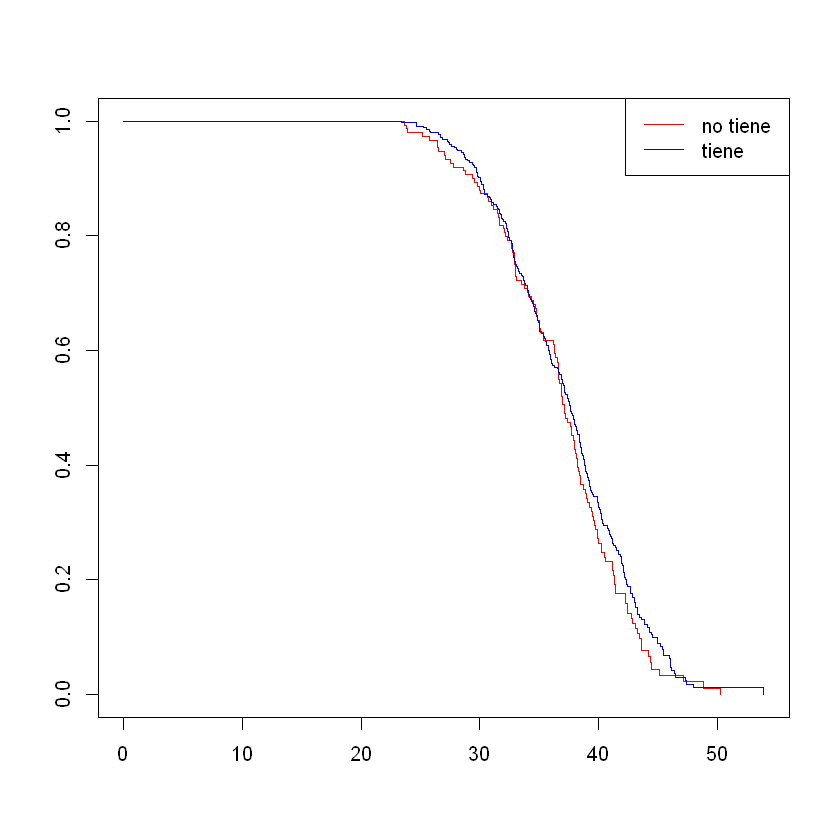

In [38]:
leg.txt<-c("no tiene", "tiene")
fit_ant <- survfit(recsurv~antec)
plot(fit_ant, col=c(2,4))
legend("topright",leg.txt,col=c(2,4),lty=1)



La dócima de Log Rank no muestra un efecto significativo de la covariable sobre la variable de interés.

In [39]:
surv<-Surv(tiempo,censura)
survdiff(surv ~ antec, rho=0)

Call:
survdiff(formula = surv ~ antec, rho = 0)

          N Observed Expected (O-E)^2/E (O-E)^2/V
antec=0 151      131      120     0.983      1.38
antec=1 349      290      301     0.393      1.38

 Chisq= 1.4  on 1 degrees of freedom, p= 0.2 

Construimos el modelo de Cox univariado para analizar las proporcionalidad de los riesgos.

In [40]:
fitcox_ant <- coxph(surv~antec)

summary(fitcox_ant)

Call:
coxph(formula = surv ~ antec)

  n= 500, number of events= 421 

         coef exp(coef) se(coef)      z Pr(>|z|)
antec -0.1242    0.8832   0.1056 -1.176     0.24

      exp(coef) exp(-coef) lower .95 upper .95
antec    0.8832      1.132    0.7181     1.086

Concordance= 0.51  (se = 0.013 )
Likelihood ratio test= 1.36  on 1 df,   p=0.2
Wald test            = 1.38  on 1 df,   p=0.2
Score (logrank) test = 1.38  on 1 df,   p=0.2


Logaritmizamos las curvas para evidenciar la proporcionalidad

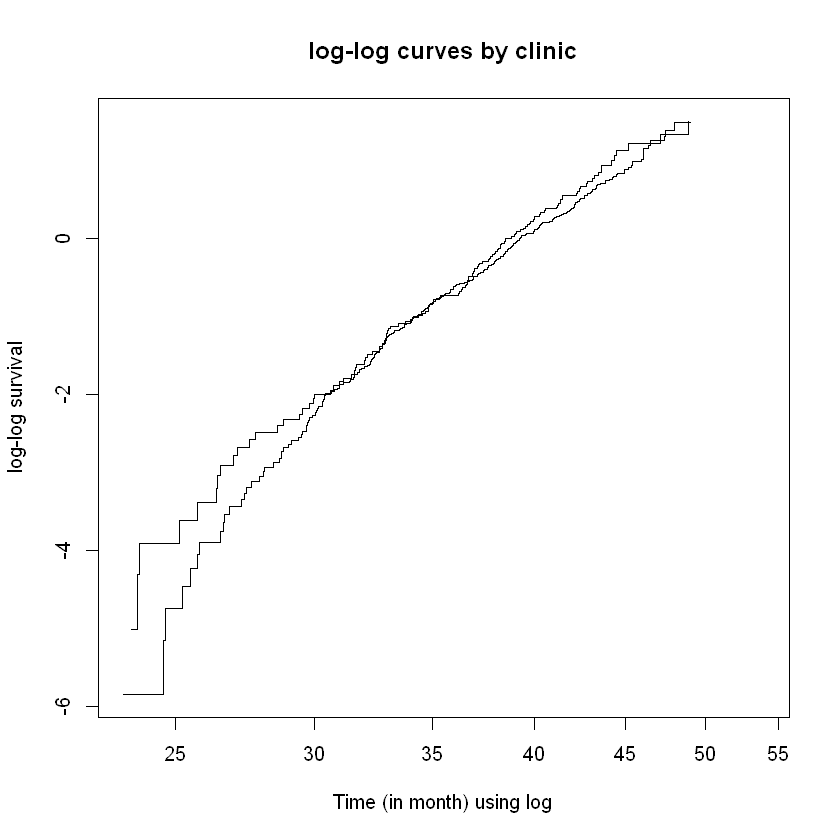

In [41]:
plot(fit_ant, fun = "cloglog", xlab = "Time (in month) using log",
     ylab = "log-log survival", main = "log-log curves by clinic") 

Analizamos los residuos de schoenfeld

`geom_smooth()` using formula 'y ~ x'


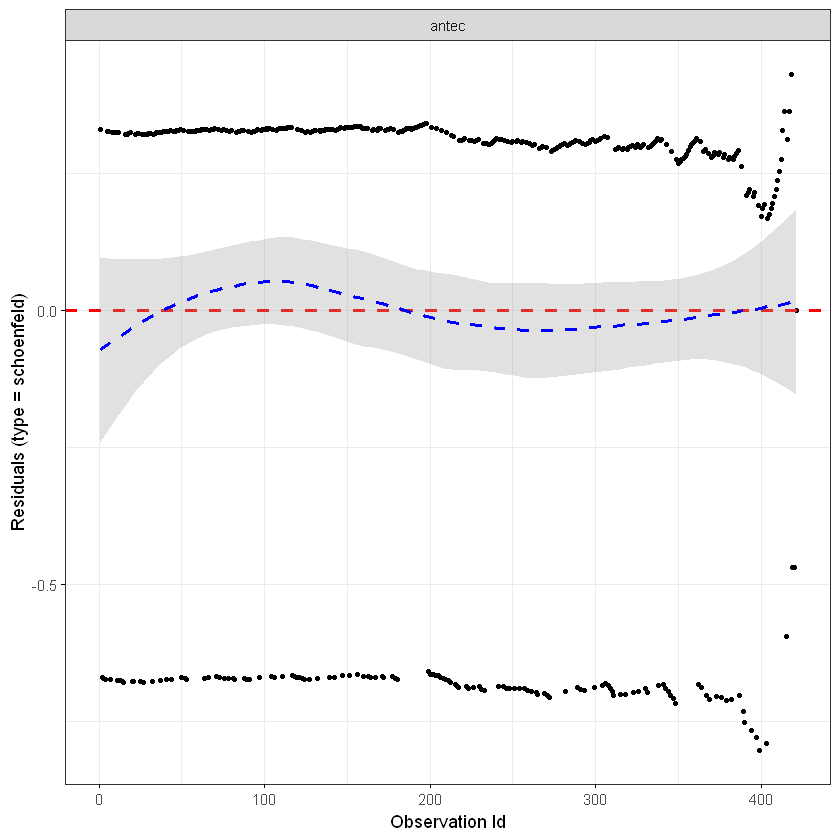

In [42]:
ggcoxdiagnostics(fitcox_ant, type = "schoenfeld")

Aplicamos el tests de proporcionalidad. Finalmente se concluye que los riesgos son proporcionales

In [43]:
cox.zph(fitcox_ant)

       chisq df    p
antec  0.247  1 0.62
GLOBAL 0.247  1 0.62

En resumen sólo la covariable antecedentes familiares no presenta un efecto significativo sobre la respuesta, sin embargo, y a diferencia de Stata, se observa proporcionalidad en los riesgos.

Buscaremos un ajuste paramétrico dentro de la familia de las exponenciales.

Los datos distribuyen exponencial?
Para ello utilizaremos el package flexsur que nos permite realizar una comparación entre la curva observada y esperada dada una determinada distribución de los datos.

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "exp")

Estimates: 
      est      L95%     U95%     se     
rate  0.02314  0.02103  0.02546  0.00113

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -2006.595, df = 1
AIC = 4015.189


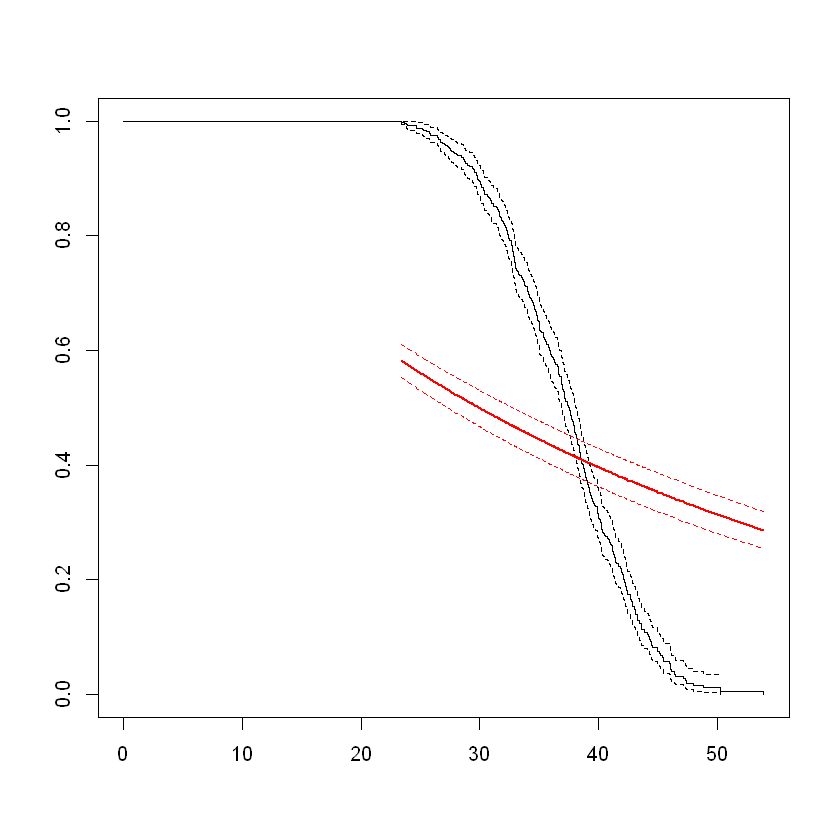

In [44]:
fit_exp<-flexsurvreg(recsurv~1, dist="exp")
fit_exp
plot(fit_exp)

No se observa un buen ajuste con la regresión exponencial

Los datos distribuyen Weibull?

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "weibull")

Estimates: 
       est     L95%    U95%    se    
shape   7.527   7.007   8.085   0.275
scale  39.537  39.028  40.053   0.262

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1381.363, df = 2
AIC = 2766.727


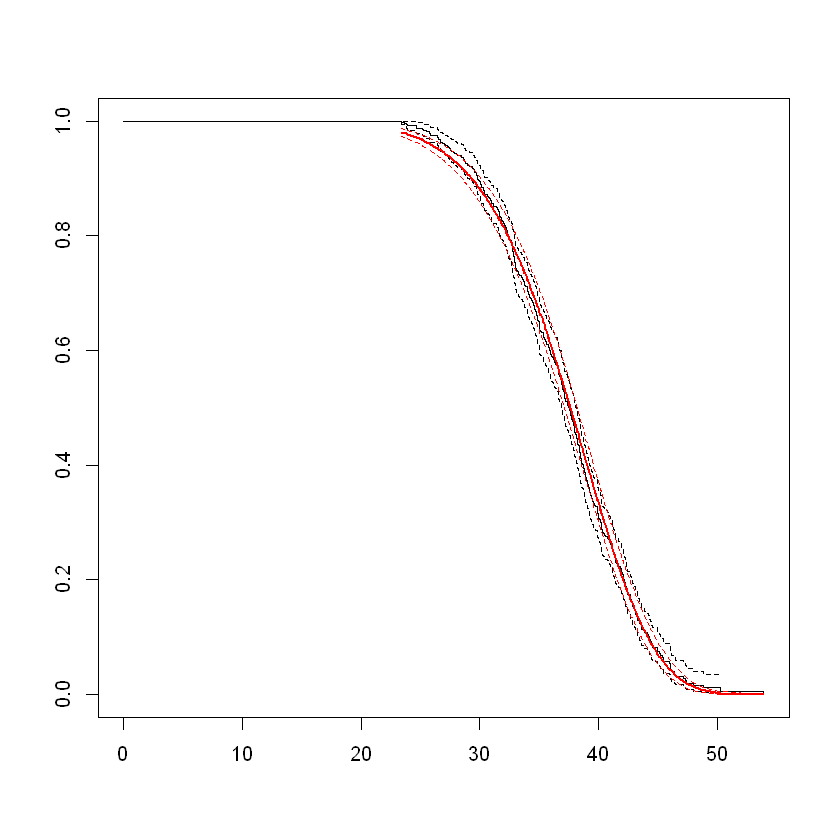

In [47]:
fit_weibull<-flexsurvreg(recsurv~1, dist="weibull")
fit_weibull
plot(fit_weibull)

Al igual que Stata, el ajuste weibull se presenta como una buena alternativa.

Los datos distribuyen gamma?

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "gamma")

Estimates: 
       est      L95%     U95%     se     
shape  42.0420  36.7603  48.0825   2.8797
rate    1.1285   0.9847   1.2934   0.0785

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1376.222, df = 2
AIC = 2756.443


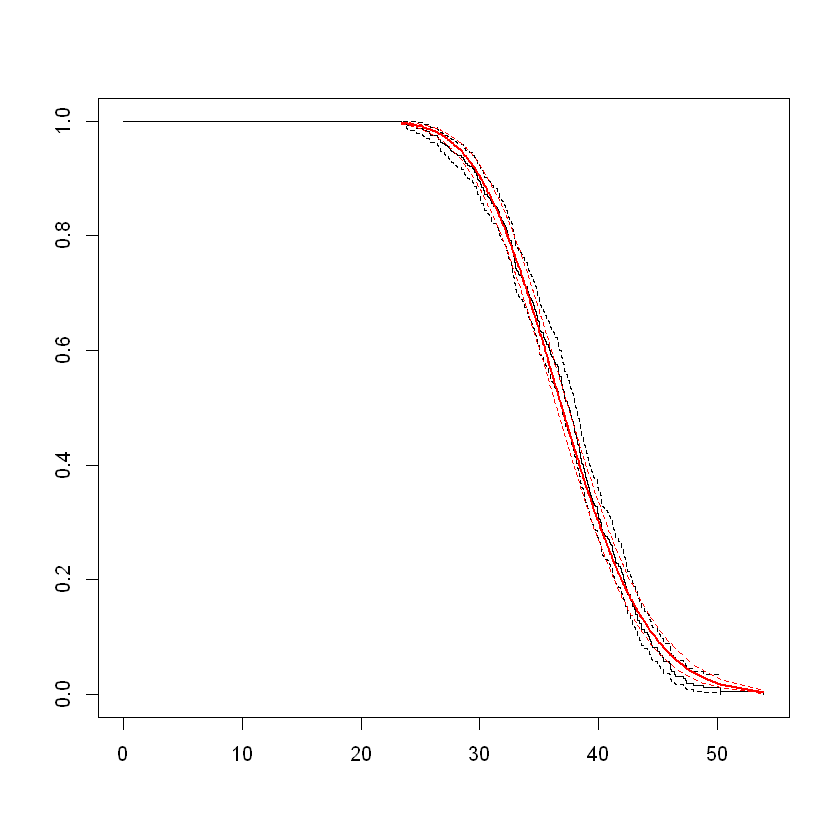

In [50]:
fit_gamma<-flexsurvreg(recsurv~1, dist="gamma")
fit_gamma
plot(fit_gamma)

Alternativamente la distribución gamma ofrece un buen ajuste 

Los datos distribuyen gengamma?

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "gengamma")

Estimates: 
       est      L95%     U95%     se     
mu     3.64039  3.61756  3.66321  0.01165
sigma  0.14597  0.13436  0.15858  0.00617
Q      0.47023  0.21139  0.72908  0.13207

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1373.421, df = 3
AIC = 2752.841


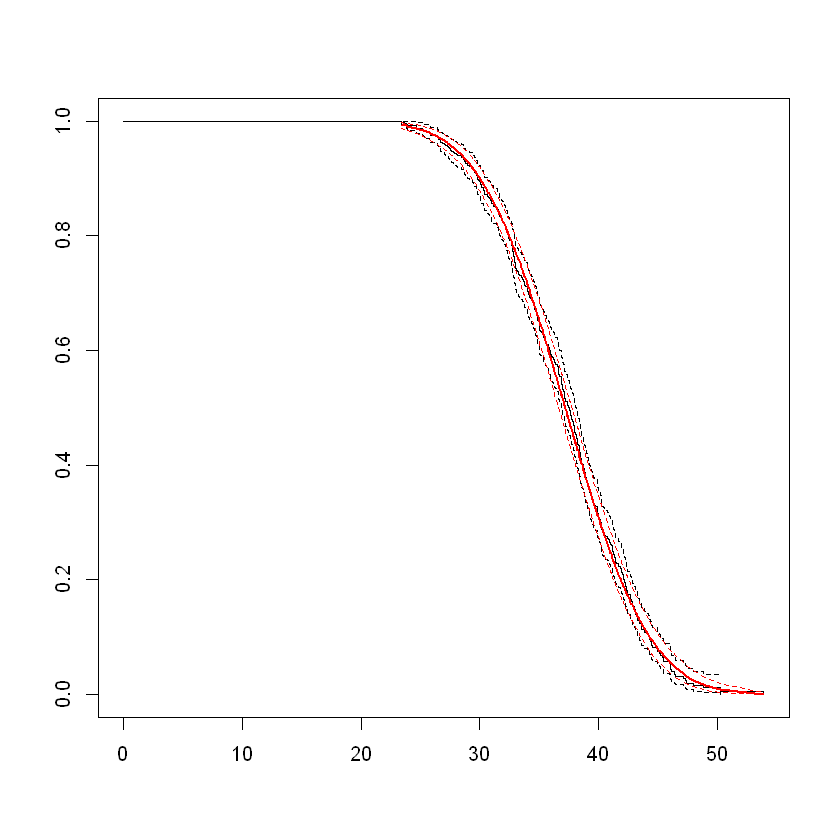

In [53]:
fit_gengamma<-flexsurvreg(recsurv~1, dist="gengamma")
fit_gengamma
plot(fit_gengamma)

Visualmente la distribución gengamma se presenta como la de mejor ajuste, sin embargo al aplicarlo en Stata no mostró resultados consistentes con el modelo de Cox.

Los datos distribuyen Lognormal?

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "lnorm")

Estimates: 
         est      L95%     U95%     se     
meanlog  3.60647  3.59215  3.62078  0.00731
sdlog    0.15726  0.14694  0.16830  0.00544

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1379.521, df = 2
AIC = 2763.042


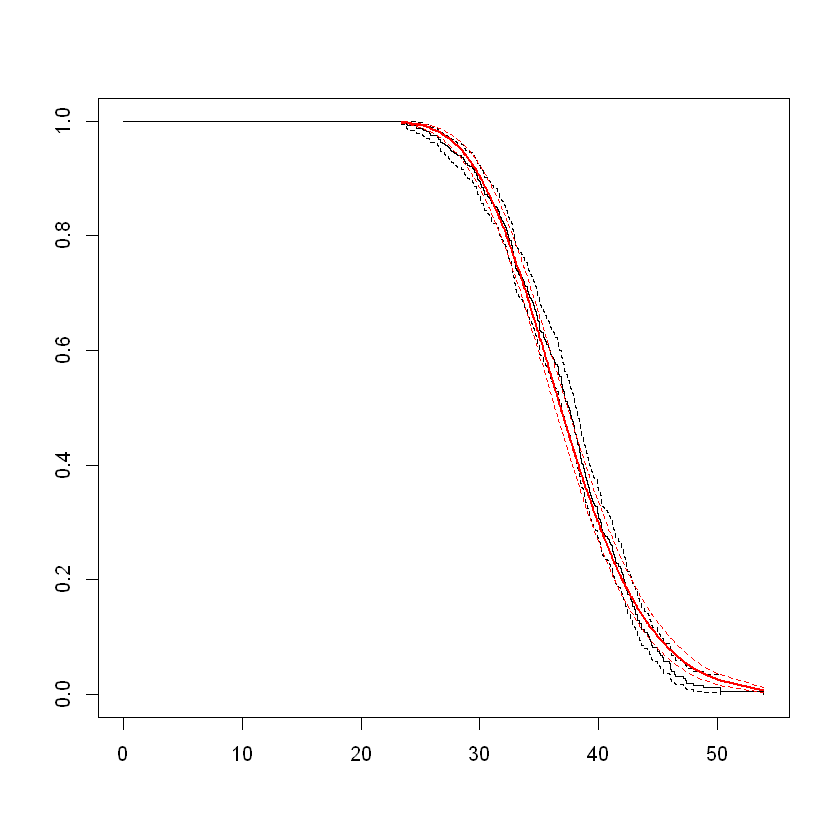

In [59]:
fit_lognormal<-flexsurvreg(recsurv~1, dist="lnorm")
fit_lognormal
plot(fit_lognormal)

Los datos distribuyen gompertz?

Call:
flexsurvreg(formula = recsurv ~ 1, dist = "gompertz")

Estimates: 
       est       L95%      U95%      se      
shape  1.92e-01  1.79e-01  2.06e-01  6.76e-03
rate   9.00e-05  5.51e-05  1.47e-04  2.25e-05

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1401.792, df = 2
AIC = 2807.585


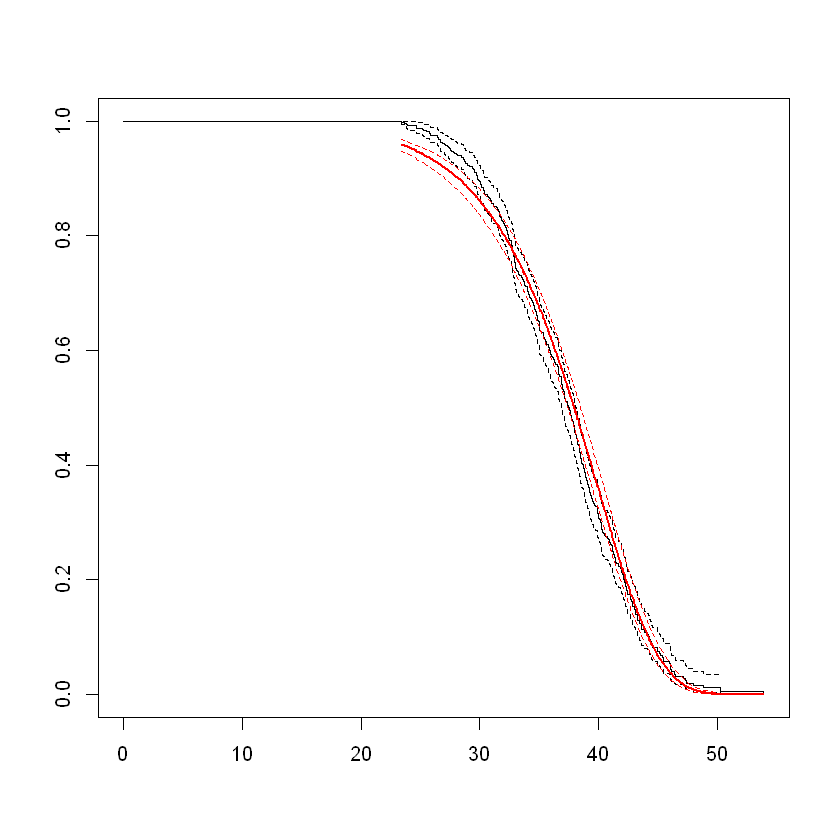

In [62]:
fit_gompertz<-flexsurvreg(recsurv~1, dist="gompertz")
fit_gompertz
plot(fit_gompertz)

Ajustaremos los datos a un modelo paramétrico.


Para hacer comparativo los modelos con Stata es necesario observar el exponente de los coeficientes que corresponde al hazar ratio.

Ajuste Exponencial 
Hazar ratio para tabaco =1.081 ; alcohol =0.866 ; antec =1.066; estadío_2 =1.1602

Los pacientes en estadío 2 tienen un riesgo relativo de un 16% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 14% menos. 

In [71]:
fit_exp<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2 , dist="exponential", data=Sobrevida)
fit_exp

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "exponential")

Estimates: 
           data mean  est       L95%      U95%      se        exp(est)
rate             NA    0.01915   0.01224   0.02998   0.00438        NA
tabaco      0.87200    0.07795  -0.32984   0.48575   0.20806   1.08107
alcohol     0.05400   -0.14371  -0.73583   0.44842   0.30211   0.86614
antec       0.69800    0.06405  -0.18818   0.31629   0.12869   1.06615
estadio_2   0.54600    0.14858  -0.10322   0.40037   0.12847   1.16019
           L95%      U95%    
rate             NA        NA
tabaco      0.71904   1.62539
alcohol     0.47911   1.56583
antec       0.82846   1.37202
estadio_2   0.90193   1.49238

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -2004.857, df = 5
AIC = 4019.713


Ajuste Weibull
Hazar ratio para tabaco =1.014 ; alcohol =0.596 ; antec =1.084; estadío_2 =1.292

Los pacientes en estadío 2 tienen un riesgo relativo de un 29% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 44% menos. 

In [75]:
fit_weibullPH<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2  , dist="weibullPH", data=Sobrevida)
fit_weibullPH

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "weibullPH")

Estimates: 
           data mean  est        L95%       U95%       se         exp(est) 
shape             NA   7.64e+00   7.11e+00   8.21e+00   2.80e-01         NA
scale             NA   5.17e-13   6.48e-14   4.12e-12   5.47e-13         NA
tabaco      8.72e-01   1.48e-02  -3.93e-01   4.23e-01   2.08e-01   1.01e+00
alcohol     5.40e-02  -5.33e-01  -1.13e+00   6.23e-02   3.04e-01   5.87e-01
antec       6.98e-01   8.12e-02  -1.71e-01   3.33e-01   1.29e-01   1.08e+00
estadio_2   5.46e-01   2.56e-01   4.37e-03   5.08e-01   1.28e-01   1.29e+00
           L95%       U95%     
shape             NA         NA
scale             NA         NA
tabaco      6.75e-01   1.53e+00
alcohol     3.24e-01   1.06e+00
antec       8.43e-01   1.40e+00
estadio_2   1.00e+00   1.66e+00

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1374.26, df =

Ajuste Gompertz
Hazar ratio para tabaco =0.997 ; alcohol =0.482 ; antec =1.08; estadío_2 =1.28

Los pacientes en estadío 2 tienen un riesgo relativo de un 28% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 48% menos.

In [78]:
fit_Gompertz<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2  , dist="gompertz", data=Sobrevida)
fit_Gompertz

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "gompertz")

Estimates: 
           data mean  est        L95%       U95%       se         exp(est) 
shape             NA   1.97e-01   1.83e-01   2.11e-01   7.09e-03         NA
rate              NA   6.56e-05   3.37e-05   1.28e-04   2.23e-05         NA
tabaco      8.72e-01  -3.41e-03  -4.11e-01   4.04e-01   2.08e-01   9.97e-01
alcohol     5.40e-02  -7.31e-01  -1.33e+00  -1.28e-01   3.07e-01   4.82e-01
antec       6.98e-01   7.88e-02  -1.73e-01   3.31e-01   1.29e-01   1.08e+00
estadio_2   5.46e-01   2.46e-01  -5.21e-03   4.98e-01   1.28e-01   1.28e+00
           L95%       U95%     
shape             NA         NA
rate              NA         NA
tabaco      6.63e-01   1.50e+00
alcohol     2.64e-01   8.80e-01
antec       8.41e-01   1.39e+00
estadio_2   9.95e-01   1.65e+00

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1392.412, df =

Ajuste LogLogistic
En general todos los HR de este ajuste son muy cercanos a 1, luego el modelo no ofrece un buen ajuste. 

In [79]:
fit_llogis<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2  , dist="llogis", data=Sobrevida)
fit_llogis

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "llogis")

Estimates: 
           data mean  est       L95%      U95%      se        exp(est)
shape            NA   11.14666  10.30533  12.05667   0.44632        NA
scale            NA   38.93591  36.53138  41.49870   1.26634        NA
tabaco      0.87200   -0.01729  -0.07434   0.03977   0.02911   0.98286
alcohol     0.05400    0.01989  -0.06313   0.10291   0.04236   1.02009
antec       0.69800   -0.01876  -0.05674   0.01922   0.01938   0.98142
estadio_2   0.54600   -0.04030  -0.07815  -0.00246   0.01931   0.96050
           L95%      U95%    
shape            NA        NA
scale            NA        NA
tabaco      0.92835   1.04057
alcohol     0.93882   1.10839
antec       0.94484   1.01941
estadio_2   0.92483   0.99755

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1378.122, df = 6
AIC = 2768.245


Ajuste Lognormal
En general todos los HR de este ajuste son muy cercanos a 1, luego el modelo no ofrece un buen ajuste. 

In [80]:
fit_lognormal<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2  , dist="lognormal", data=Sobrevida)
fit_lognormal

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "lognormal")

Estimates: 
           data mean  est        L95%       U95%       se         exp(est) 
meanlog           NA   3.655301   3.589749   3.720854   0.033446         NA
sdlog             NA   0.156124   0.145894   0.167071   0.005398         NA
tabaco      0.872000  -0.022228  -0.081051   0.036595   0.030012   0.978018
alcohol     0.054000   0.024591  -0.058286   0.107469   0.042285   1.024896
antec       0.698000  -0.013729  -0.051879   0.024421   0.019465   0.986365
estadio_2   0.546000  -0.038036  -0.075766  -0.000306   0.019250   0.962678
           L95%       U95%     
meanlog           NA         NA
sdlog             NA         NA
tabaco      0.922147   1.037273
alcohol     0.943380   1.113456
antec       0.949444   1.024721
estadio_2   0.927033   0.999694

N = 500,  Events: 421,  Censored: 79
Total time at risk: 18194.79
Log-likelihood = -1374.575, df 

Ajuste gengamma
En general todos los HR de este ajuste son muy cercanos a 1, luego el modelo no ofrece un buen ajuste. 

In [82]:
fit_gengamma<-flexsurvreg(formula=Surv(tiempo, censura)~  tabaco + alcohol+ antec + estadio_2  , dist="gengamma", data=Sobrevida)
fit_gengamma

Call:
flexsurvreg(formula = Surv(tiempo, censura) ~ tabaco + alcohol + 
    antec + estadio_2, data = Sobrevida, dist = "gengamma")

Estimates: 
           data mean  est       L95%      U95%      se        exp(est)
mu               NA    3.68023   3.61683   3.74364   0.03235        NA
sigma            NA    0.14395   0.13222   0.15672   0.00625        NA
Q                NA    0.50325   0.23521   0.77129   0.13676        NA
tabaco      0.87200   -0.01136  -0.06788   0.04515   0.02883   0.98870
alcohol     0.05400    0.04344  -0.03792   0.12479   0.04151   1.04439
antec       0.69800   -0.01332  -0.04904   0.02240   0.01823   0.98677
estadio_2   0.54600   -0.03728  -0.07275  -0.00180   0.01810   0.96341
           L95%      U95%    
mu               NA        NA
sigma            NA        NA
Q                NA        NA
tabaco      0.93438   1.04619
alcohol     0.96279   1.13291
antec       0.95214   1.02266
estadio_2   0.92983   0.99820

N = 500,  Events: 421,  Censored: 79
Total tim

Modelo semiparamétrico de riesgos proporcionales de Cox
El modelo semiparamétrico resultó ser muy similar a la propuesta paramétrica de weibull y gompertz mostrando un 28% de mayor riesgo relativo en la variable estadío, y un 34% de protección debido al consumo de alcohol.

In [86]:
fit <- coxph(surv~ tabaco + alcohol+ antec + estadio_2 , data=Sobrevida)

In [87]:
summary(fit)

Call:
coxph(formula = surv ~ tabaco + alcohol + antec + estadio_2, 
    data = Sobrevida)

  n= 500, number of events= 421 

              coef exp(coef) se(coef)      z Pr(>|z|)  
tabaco     0.01739   1.01754  0.20836  0.083   0.9335  
alcohol   -0.40446   0.66734  0.30940 -1.307   0.1911  
antec      0.07128   1.07388  0.12910  0.552   0.5809  
estadio_2  0.24998   1.28399  0.12880  1.941   0.0523 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

          exp(coef) exp(-coef) lower .95 upper .95
tabaco       1.0175     0.9828    0.6764     1.531
alcohol      0.6673     1.4985    0.3639     1.224
antec        1.0739     0.9312    0.8338     1.383
estadio_2    1.2840     0.7788    0.9975     1.653

Concordance= 0.544  (se = 0.015 )
Likelihood ratio test= 10.39  on 4 df,   p=0.03
Wald test            = 9.6  on 4 df,   p=0.05
Score (logrank) test = 9.76  on 4 df,   p=0.04


Salvo la lógica utilizada para identificar la existencia de riesgos proporcionales, los resultados observados son similares a los encontrados en Stata, aunque algunos coeficientes no resultan ser del todo exactos, lo que puede estar explicado con leves variaciones en la programación de los algoritmos de sobrevida.